### Mutual information betwen FC and stimulus

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

#### Load data

In [2]:
# Root path
root = os.path.expanduser("~/funcog/gda/Results/lucy/mutual_information/")
# Load data for coherence
tval = xr.load_dataarray(os.path.join(root, "t_coh_avg_1_thr_1_fdr.nc"))
pval = xr.load_dataarray(os.path.join(root, "pval_coh_avg_1_thr_1_fdr.nc"))
t_coh = tval * (pval <= 0.05)

# Load data for plv
tval = xr.load_dataarray(os.path.join(root, "t_plv_avg_1_thr_1_fdr.nc"))
pval = xr.load_dataarray(os.path.join(root, "pval_plv_avg_1_thr_1_fdr.nc"))
t_plv = tval * (pval <= 0.05)

#### Number of significant effects per task stage

In [20]:
n_freqs = t_coh.sizes["freqs"]
n_times = t_coh.sizes["times"]


n_effects_coh = np.zeros((n_freqs, n_times))
n_effects_plv = np.zeros((n_freqs, n_times))

for f in range(n_freqs):
    for t in range(n_times):
        n_effects_coh[f, t] = (t_coh.isel(freqs=f, times=t) > 0).sum()
        n_effects_plv[f, t] = (t_plv.isel(freqs=f, times=t) > 0).sum()

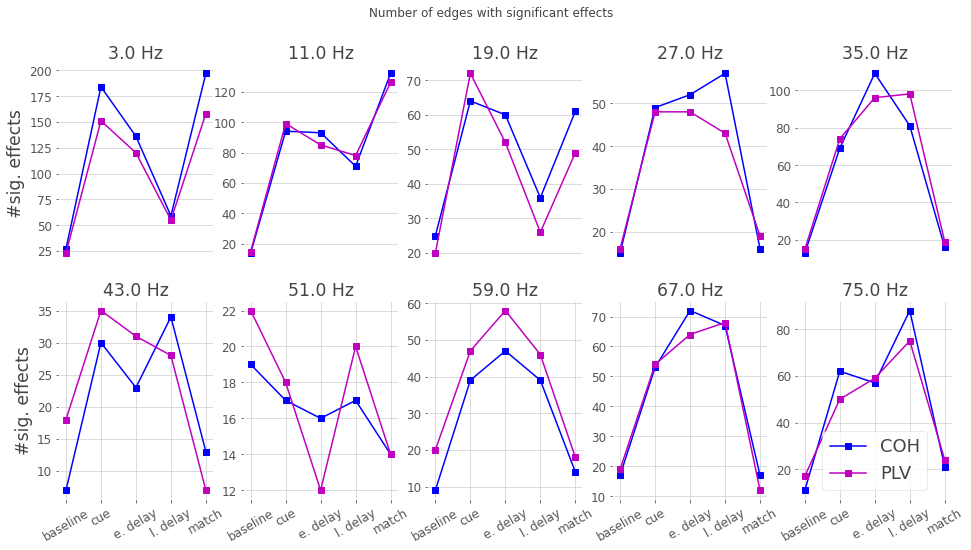

In [23]:
plt.figure(figsize=(16, 8))
for f in range(n_freqs):
    ax = plt.subplot(2, n_freqs // 2, f + 1)
    plt.plot(n_effects_coh[f], "s-", label="COH", color="b")
    plt.plot(n_effects_plv[f], "s-", label="PLV", color="m")
    plt.title(f"{t_coh.freqs.data[f]} Hz")
    # plt.ylim(1, 10)
    if f < 5:
        plt.xticks([])
    else:
        plt.xticks(
            range(5), ["baseline", "cue", "e. delay", "l. delay", "match"], rotation=30
        )
    if f == 0 or f == 5:
        plt.ylabel("#sig. effects")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
plt.suptitle("Number of edges with significant effects")
plt.legend()

In [3]:
t_coh = t_coh > 0

In [4]:
from GDa.net.layerwise import compute_network_partition
from GDa.net.util import convert_to_adjacency
from GDa.util import _extract_roi

In [5]:
compute_network_partition?

Signature:
compute_network_partition(
    A,
    kw_bc={},
    backend='igraph',
    n_jobs=1,
    verbose=False,
)
Docstring:
Given the multiplex adjacency matrix A with shape (roi,roi,trials*time),
the network partition for each node is computed for all
the trials concatenated.

Parameters
----------
A: array_like
    Multiplex adjacency matrix with shape (roi,roi,trials,time).
kw_bc: dict | {}
    Parameters to be passed to brainconn implementation
backend: string | "igraph"
    Wheter to use igraph or brainconn package.
n_jobs: int | 1
    Number of jobs to use when parallelizing in observations.

Returns
-------
partition:
    A list with the all the partition found for each layer of the
File:      ~/storage1/projects/GrayData-Analysis/GDa/net/layerwise.py
Type:      function


In [6]:
convert_to_adjacency?

Signature:
convert_to_adjacency(
    tensor,
    sources,
    targets,
    areas=None,
    dtype=<class 'numpy.float32'>,
)
Docstring:
Convert the tensor with the edge time-series to a matrix representations.

Parameters
----------
tensor: array_like
    The tensor with the edge time series (roi,freqs,trials,times).
sources: array_like
    list of source nodes.
targets: array_like
    list of target nodes.

Returns
-------
The adjacency matrix (roi,roi,freqs,trials,times).
File:      ~/storage1/projects/GrayData-Analysis/GDa/net/util.py
Type:      function


In [7]:
roi_s, roi_t = _extract_roi(t_coh.roi.data, "-")

In [8]:
areas = np.unique(np.stack((roi_s, roi_t)))
n_areas = len(areas)

In [9]:
mapping = dict(zip(areas, range(n_areas)))

In [10]:
sources = [mapping[a] for a in roi_s]
targets = [mapping[a] for a in roi_t]

In [39]:
A = convert_to_adjacency(
    t_coh.expand_dims("trials", 2).transpose("roi", "freqs", "trials", "times"),
    sources,
    targets,
    areas=areas,
).sel(freqs=35.)

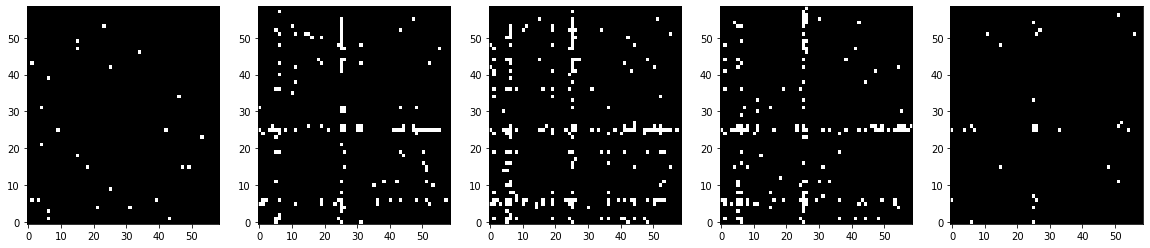

In [14]:
plt.figure(figsize=(20, 4))
for t in range(5):
    plt.subplot(1, 5, t+1)
    plt.imshow(A[..., t].squeeze(), aspect="auto", cmap="binary_r", origin = "lower")

In [41]:
p, m =  compute_network_partition(A, backend="igraph")
p = p.squeeze()
A = A.squeeze()

  0%|          |  : 0/5 [00:00<?,       ?it/s]

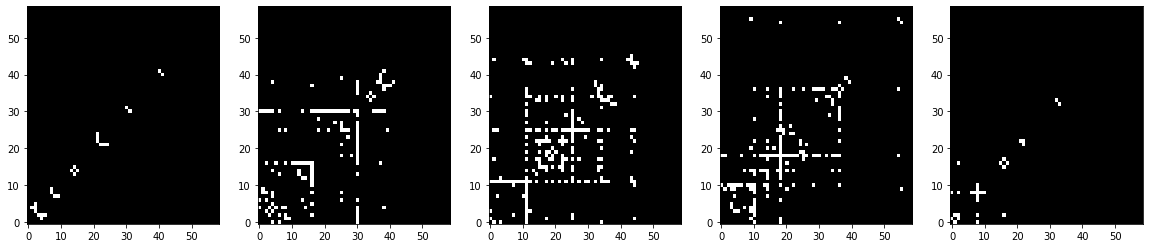

In [58]:
plt.figure(figsize=(20, 4))

for t in range(5):
    plt.subplot(1, 5, t+1)
    idx = np.argsort(p.squeeze().isel(times=t).data)
    plt.imshow(A[..., t].data[np.ix_(idx, idx)].squeeze(), aspect="auto", cmap="binary_r", origin = "lower")